In [21]:
import json
import itertools
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
from scipy.stats import *
from collections import defaultdict
from utils import get_session_ids, get_all_sequences, get_topics, get_sub_topics, RegExp, product,to_matrix
from search_engine import *
from numpy.random import choice
from tqdm.notebook import tqdm
from multiprocessing import Pool

np.set_printoptions(precision=3)

In [22]:
path_log = './data/log.2.tsv'
path_topic = './data/topic.tsv'
path_sub_topic = './data/sub_topic.tsv'
path_retrievable_paragraph = './data/retrievable_paragraph.tsv'

In [3]:
session_ids = get_session_ids(path_log)
all_sequences = get_all_sequences(path_log, session_ids)

In [4]:
topics = get_topics(path_topic)

#topics

In [5]:
# topic -> sub_topic -> queries
all_queries = {}

for topic in all_sequences:
    
    queries = defaultdict(list)
    for sequence in all_sequences[topic]:
        for action in sequence:
            sub_topic = action[3]
            query = action[4]
            queries[sub_topic].append(query)
    
    all_queries[topic] = queries

#all_queries

In [6]:
# topic -> sub_topic -> paragraphs
qrels = defaultdict(dict)

sub_topic_to_paragraph = defaultdict(set)
with open(path_retrievable_paragraph) as f:
    for line in f.readlines()[1:]:
        items = line.split('\t')
        sub_topic = int(items[0])
        paragraph = int(items[1])
        sub_topic_to_paragraph[sub_topic].add(paragraph)

sub_topics = get_sub_topics(path_sub_topic)

for topic in sub_topics:
    for sub_topic in sub_topics[topic]:
        qrels[topic][sub_topic] = sub_topic_to_paragraph[sub_topic]

#qrels

In [7]:
# from users binary
# topic -> sub_topic -> paragraphs
qrels_users = {}

for topic in sub_topics:
    for sequence in all_sequences[topic]:
        for action in sequence:
            paragraph = action[1]
            rel = action[2]
            sub_topic = action[3]
            if rel == 'relevant':
                if topic not in qrels_users:
                    qrels_users[topic] = {}
                if sub_topic not in qrels_users[topic]:
                    qrels_users[topic][sub_topic] = set()
                qrels_users[topic][sub_topic].add(paragraph)

#qrels_users

In [8]:
# from users continuos
# topic -> sub_topic -> paragraphs
qrels_users = {}

for topic in sub_topics:
    for sequence in all_sequences[topic]:
        for action in sequence:
            paragraph = action[1]
            rel = action[2]
            sub_topic = action[3]
            if topic not in qrels_users:
                qrels_users[topic] = {}
            if sub_topic not in qrels_users[topic]:
                qrels_users[topic][sub_topic] = {}
            if paragraph not in qrels_users[topic][sub_topic]:
                qrels_users[topic][sub_topic][paragraph] = (0, 0)
            num, den = qrels_users[topic][sub_topic][paragraph]
            if rel == 'relevant':
                qrels_users[topic][sub_topic][paragraph] = (num + 1, den + 1)
            else:
                qrels_users[topic][sub_topic][paragraph] = (num, den + 1)

for topic in qrels_users:
    for sub_topic in qrels_users[topic]:
        for paragraph in qrels_users[topic][sub_topic]:
            num, den = qrels_users[topic][sub_topic][paragraph]
            qrels_users[topic][sub_topic][paragraph] = num/den
            
#qrels_users

In [9]:
direct_index = DirectIndex.load()

In [10]:
pre_preocessor = PreProcessor()

def select_random_documents(documents:set, p:float=0.0):
    assert(0.0 <= p <= 1.0)
    if p == 0.0:
        return set()
    elif p == 1.0:
        return documents
    else:
        return set(choice(list(documents), replace=False, size = int(len(documents) * p)))
        
def get_search_engine(topic, sub_topic, qrels, direct_index, noise = 0.0):
    # select documents belonging to the topic
    selected_documents = {}
    for document in qrels[topic][sub_topic]:
        selected_documents[document] = direct_index.index[document]
        
    # select random documents
    # 1. from topic documents
    topic_documents = set()
    for _, sub_topic_documents in qrels[topic].items():
        topic_documents.update(sub_topic_documents)    
    topic_documents = select_random_documents(topic_documents, noise)
    
    for document in topic_documents:
        selected_documents[document] = direct_index.index[document]
    
    # 2. from all_documents
    all_documents = direct_index.index.keys()
    all_documents = select_random_documents(all_documents, noise)

    for document in all_documents:
        selected_documents[document] = direct_index.index[document]
        
    # retrievable documents
    inverted_index = InvertedIndex()
    inverted_index.create(selected_documents)
        
    return selected_documents, inverted_index

# stats
inverted_index = InvertedIndex()
inverted_index.create(direct_index.index)

# test
for topic in sub_topics:
    for sub_topic in sub_topics[topic]:
        print(topic, topics[topic], sub_topic)
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index, 0.01)
        print("over", len(r_documents), "documents")
        r_inverted_index.cl = inverted_index.cl
        r_inverted_index.dictionary = inverted_index.dictionary
        search = Search(r_inverted_index, pre_preocessor)
        print(search.search('amazon', n=2, retrievable_paragraphs=r_documents.keys()))
    break

10 amazon rainforest 1
over 204 documents
[374, 236]
10 amazon rainforest 2
over 203 documents
[371, 22]
10 amazon rainforest 3
over 205 documents
[381, 379]
10 amazon rainforest 4
over 204 documents
[386, 75]
10 amazon rainforest 5
over 203 documents
[371, 5]


# Correlation Analysis

In [11]:
# CP

def dd_cp(alpha, m, l):
    return 1

def ncp(sequence):
    res = 0.0
    for action in sequence:
        if action[2] == 'relevant':
            res += dd_cp(None, None, None)
    return res/len(sequence)

def get_ncp_list(sequences):
    res = []
    for sequence in sequences:
        res.append(ncp(sequence))
    return res

# CBP

def dd_cbp(alpha, m, l = None):
    return alpha ** m

def dd_ncbp(alpha, m, l):
    norm = 0.0
    for i in range(l):
        norm += dd_cbp(alpha, i, l)
    return dd_cbp(alpha, m, l) / norm

def ncbp(sequence, alpha):
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp(alpha, m, len(sequence))
    return res

def get_ncbp_list(sequences, alpha):
    res = []
    for sequence in sequences:
        res.append(ncbp(sequence, alpha))
    return res

# CBP +

def dd_ncbp_p(alpha, beta, m, sequence):
    res = 1.0
    for action in sequence[:m]:
        if action[2] == 'relevant':
            res *= alpha
        else:
            res *= beta
    norm = 0.0
    for i in range(len(sequence)):
        norm += dd_cbp(alpha, i)
    return res / norm

def ncbp_p(sequence, alpha, beta):
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp_p(alpha, beta, m, sequence)
    return res

def get_ncbp_p_list(sequences, alpha, beta):
    res = []
    for sequence in sequences:
        res.append(ncbp_p(sequence, alpha, beta))
    return res

# Simulations

In [12]:
def generate_sequence(num_subtopics, min_sub_topics = 1):
    prob = 1.0
    sequence = []
    current_subtopic = 0
    
    next_subtopic = choice(range(1, num_subtopics + 1), 1)[0]
    prob *= 1.0/num_subtopics
    sequence.append((current_subtopic, None, None, next_subtopic + min_sub_topics - 1, None))
    current_subtopic = next_subtopic
    
    while next_subtopic + min_sub_topics - 1 != num_subtopics + 1 + min_sub_topics - 1:
        next_subtopic = choice(range(1, num_subtopics + 2), 1)[0]
        prob *= 1.0/(num_subtopics + 1)
        sequence.append((current_subtopic + min_sub_topics - 1, 
                         None, None, 
                         next_subtopic + min_sub_topics - 1, None))
        current_subtopic = next_subtopic
        
    return sequence, prob

sequence, prob = generate_sequence(5)

print(sequence)

print(sequence[:-1])

[(0, None, None, 2, None), (2, None, None, 4, None), (4, None, None, 5, None), (5, None, None, 2, None), (2, None, None, 5, None), (5, None, None, 3, None), (3, None, None, 4, None), (4, None, None, 6, None)]
[(0, None, None, 2, None), (2, None, None, 4, None), (4, None, None, 5, None), (5, None, None, 2, None), (2, None, None, 5, None), (5, None, None, 3, None), (3, None, None, 4, None)]


In [13]:
def get_transitions_table(num_subtopics, min_sub_topic, sequences, epsilon = 0.0):
    transitions_table = defaultdict(float)
    for sequence in sequences:
        last_key = None
        for n, action in enumerate(sequence):
            if n == 0:
                key = (action[0], action[3] - min_sub_topic + 1)
            else:
                key = (action[0] - min_sub_topic + 1, action[3] - min_sub_topic + 1)
            transitions_table[key] += 1
            last_key = key
        transitions_table[(last_key[1], num_subtopics+1)] += 1
    
    norms = defaultdict(float)
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if not (from_subtopic == 0 and to_subtopic == num_subtopics + 1):            
            transitions_table[(from_subtopic, to_subtopic)] += epsilon
        norms[from_subtopic] += transitions_table[(from_subtopic, to_subtopic)]
    
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if norms[from_subtopic] > 0.0:
            transitions_table[(from_subtopic, to_subtopic)] /= norms[from_subtopic]
            
    return transitions_table

#get_transitions_table(len(sub_topics[1]), min(sub_topics[1]), all_sequences[1])

def generate_sequence_from_table(num_subtopics, min_sub_topics, table):
    prob = 1.0
    table = to_matrix(table)
    sequence = []
    current_subtopic = 0
    
    next_subtopic = choice(range(1, num_subtopics + 2), 1, p=table[0])[0]
    prob *= table[0, next_subtopic - 1]
    sequence.append((current_subtopic, None, None, next_subtopic + min_sub_topics - 1, None))
    current_subtopic = next_subtopic
    
    while next_subtopic + min_sub_topics - 1 != num_subtopics + 1 + min_sub_topics - 1:
        next_subtopic = choice(range(1, num_subtopics + 2), 1, p=table[current_subtopic])[0]
        prob *= table[current_subtopic, next_subtopic-1]
        sequence.append((current_subtopic + min_sub_topics - 1, 
                         None, None, 
                         next_subtopic + min_sub_topics - 1, None))
        current_subtopic = next_subtopic
    
    return sequence, prob
    
transitions_table = get_transitions_table(len(sub_topics[1]), min(sub_topics[1]), all_sequences[1])
#generate_sequence_from_table(len(sub_topics[1]), min(sub_topics[1]), transitions_table)

In [14]:
def get_transitions_tables(num_subtopics, min_sub_topic, sequences, epsilon = 0.0):
    rel_transitions_table = defaultdict(float)
    irr_transitions_table = defaultdict(float)
    p_rel = defaultdict(float)
    p_irr = defaultdict(float)
    for sequence in sequences:
        last_key = None
        last_rel = 'irrelevant'
        for n, action in enumerate(sequence):
            if n == 0:
                key = (action[0], action[3] - min_sub_topic + 1)
            else:
                key = (action[0] - min_sub_topic + 1, action[3] - min_sub_topic + 1)
            if last_rel == 'relevant':
                rel_transitions_table[key] += 1
                p_rel[key[0]] += 1
            else:
                irr_transitions_table[key] += 1
                p_irr[key[0]] += 1
            last_key = key
            last_rel = action[2]
        
        if last_rel == 'relevant':
            rel_transitions_table[(last_key[1], num_subtopics+1)] += 1
            p_rel[last_key[1]] += 1
        else:
            irr_transitions_table[(last_key[1], num_subtopics+1)] += 1
            p_irr[last_key[1]] += 1
        
    rel_norms = defaultdict(float)
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if from_subtopic > 0:            
            rel_transitions_table[(from_subtopic, to_subtopic)] += epsilon
        rel_norms[from_subtopic] += rel_transitions_table[(from_subtopic, to_subtopic)]
    
    irr_norms = defaultdict(float)
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if not (from_subtopic == 0 and to_subtopic == num_subtopics + 1):
            irr_transitions_table[(from_subtopic, to_subtopic)] += epsilon
        irr_norms[from_subtopic] += irr_transitions_table[(from_subtopic, to_subtopic)]
    
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if rel_norms[from_subtopic] > 0.0:
            rel_transitions_table[(from_subtopic, to_subtopic)] /= (rel_norms[from_subtopic]) 
    
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if irr_norms[from_subtopic] > 0.0:
            irr_transitions_table[(from_subtopic, to_subtopic)] /= (irr_norms[from_subtopic])
    
    p = []
    for t in range(num_subtopics + 1):
        if (p_rel[t] + p_irr[t]) > 0:
            p.append(p_rel[t]/(p_rel[t] + p_irr[t]))
        else:
            p.append(0.0)
    p = np.array([p])

    return rel_transitions_table, irr_transitions_table, p, 1 - p

for topic in topics:
    t1, t2, p_rel, p_irr = get_transitions_tables(len(sub_topics[topic]), 
                                                  min(sub_topics[topic]), all_sequences[topic], 0.0)
    #print(p_rel, p_irr)
    #print(to_matrix(transitions_table))
    print(topic)
    print(to_matrix(t1)) 
    print(to_matrix(t2))
    print()
#print((to_matrix(t1).T * p_rel).T + (to_matrix(t2).T * p_irr).T)

1
[[0.    0.    0.    0.    0.    0.   ]
 [0.    0.222 0.222 0.111 0.333 0.111]
 [0.167 0.    0.167 0.5   0.    0.167]
 [0.154 0.154 0.    0.231 0.154 0.308]
 [0.3   0.1   0.4   0.    0.2   0.   ]
 [0.    0.222 0.222 0.222 0.    0.333]]
[[0.182 0.    0.545 0.    0.273 0.   ]
 [0.    0.    0.    0.    0.    1.   ]
 [0.    0.5   0.    0.    0.5   0.   ]
 [0.    0.2   0.6   0.2   0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.4   0.    0.    0.    0.4   0.2  ]]

2
[[0.    0.    0.    0.    0.    0.   ]
 [0.    0.44  0.28  0.16  0.04  0.08 ]
 [0.111 0.056 0.167 0.389 0.222 0.056]
 [0.    0.074 0.37  0.111 0.407 0.037]
 [0.05  0.05  0.55  0.1   0.05  0.2  ]
 [0.077 0.    0.    0.115 0.192 0.615]]
[[0.808 0.077 0.077 0.    0.038 0.   ]
 [0.    0.    0.5   0.5   0.    0.   ]
 [0.    0.667 0.333 0.    0.    0.   ]
 [0.1   0.1   0.    0.2   0.5   0.1  ]
 [0.    0.    0.333 0.333 0.333 0.   ]
 [0.    0.2   0.2   0.    0.4   0.2  ]]

3
[[0.    0.    0.    0.    0.    0.    0.   ]
 [0.095

In [15]:
class SequenceGenerator:
    
    def __init__(self, num_subtopics, min_sub_topic, rel_table, irr_table):
        self.num_subtopics = num_subtopics
        self.rel_table = to_matrix(rel_table)
        self.irr_table = to_matrix(irr_table)
        self.min_sub_topic = min_sub_topic
        self.relevance = False
        self.current_subtopic = 0
        
    def __iter__(self):
        #self.current_subtopic = 0
        return self
    
    def set_relevance(self, relevance):
        self.relevance = relevance
    
    def __next__(self):
        next_subtopic = -1
        prob = -1
        if self.current_subtopic + self.min_sub_topic - 1 == self.num_subtopics + 1 + self.min_sub_topic - 1:
            raise StopIteration
        if self.relevance:
            #print(self.rel_table[self.current_subtopic].sum())
            next_subtopic = choice(range(1, self.num_subtopics + 2), 
                                   1, 
                                   p=self.rel_table[self.current_subtopic])[0]
            prob = self.rel_table[self.current_subtopic, next_subtopic - 1]
        else:
            #print(self.irr_table[self.current_subtopic].sum())
            next_subtopic = choice(range(1, self.num_subtopics + 2), 
                                   1, 
                                   p=self.irr_table[self.current_subtopic])[0]
            prob = self.irr_table[self.current_subtopic, next_subtopic - 1]
        self.current_subtopic = next_subtopic
        return next_subtopic + self.min_sub_topic - 1, prob
    
#sg = SequenceGenerator(len(sub_topics[10]), min(sub_topics[10]), t1, t2)
##for i in sg:
#    print(i)
#    sg.set_relevance(False)

In [16]:
def dd_cp_pp(alpha, beta, m, sequence, acc_value = 1.0):
    return sequence[m][5]

def dd_cp(alpha, beta, m, sequence, acc_value = 1.0):
    return 1

def dd_cbp(alpha, beta, m, sequence, acc_value = 1.0):
    if m == 0:
        return 1.0
    else:
        res = acc_value*alpha
        return res
    
def dd_cbp_p(alpha, beta, m, sequence, acc_value = 1.0):
    if m == 0:
        return 1.0
    else:
        res = acc_value
        action = sequence[m]
        if action[2] == 'relevant':
            res *= alpha
        else:
            res *= beta
        return res

In [26]:
num_samples = 100000

In [17]:
# CP

def dd_cp(alpha, m, l):
    return 1

def ncp(sequence):
    res = 0.0
    for action in sequence:
        if action[2] == 'relevant':
            res += dd_cp(None, None, None)
    return res/len(sequence)

def get_ncp_list(sequences):
    res = []
    for sequence in sequences:
        res.append(ncp(sequence))
    return res

# CBP

def dd_cbp(alpha, m, l = None):
    return alpha ** m

def dd_ncbp(alpha, m, l):
    norm = 0.0
    for i in range(l):
        norm += dd_cbp(alpha, i, l)
    return dd_cbp(alpha, m, l) / norm

def ncbp(sequence, alpha):
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp(alpha, m, len(sequence))
    return res

def get_ncbp_list(sequences, alpha):
    res = []
    for sequence in sequences:
        res.append(ncbp(sequence, alpha))
    return res

# CBP +

def dd_ncbp_p(alpha, beta, m, sequence):
    res = 1.0
    for action in sequence[:m]:
        if action[2] == 'relevant':
            res *= alpha
        else:
            res *= beta
    norm = 0.0
    for i in range(len(sequence)):
        norm += dd_cbp(alpha, i)
    return res/norm

def ncbp_p(sequence, alpha, beta):
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp_p(alpha, beta, m, sequence)
    return res

def get_ncbp_p_list(sequences, alpha, beta):
    res = []
    for sequence in sequences:
        res.append(ncbp_p(sequence, alpha, beta))
    return res

# Noise Analysis

In [18]:
# comparison of a system with without filtering, or with noise
# compute transition on sessions using the transition probabilities.
num_samples = 10000

res = 100

means = []
for noise in tqdm(range(0, res+1)):
    noise = noise/res

    topic_scores = []
    for topic in tqdm(topics):
        num_subtopics = len(sub_topics[topic])

        all_r_documents = {}
        all_r_inverted_index = {}
        for sub_topic in sub_topics[topic]:
            r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index, noise)
            all_r_documents[sub_topic] = r_documents
            all_r_inverted_index[sub_topic] = r_inverted_index

        rel_table, irr_table, p_rel, _ = get_transitions_tables(num_subtopics, 
                                                                min(sub_topics[topic]), 
                                                                all_sequences[topic], 
                                                                10e-6)
        scores = []
        for _ in range(num_samples):
            sg = SequenceGenerator(num_subtopics, min(sub_topics[topic]), rel_table, irr_table)
            prob = 1.0
            prev_sub_topic = 0
            sequence = []
            for m, (sub_topic, prob_action) in enumerate(sg):

                if sub_topic != num_subtopics + 1 + min(sub_topics[topic]) - 1:
                    query = ''
                    if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                        queries = all_queries[topic][sub_topic]
                        query = queries[choice(range(len(queries)))]

                    search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
                    answer = search.search(query, 
                                           n=1, 
                                           retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

                    if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic] and \
                    np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                        sg.set_relevance(True)
                        sequence.append((prev_sub_topic, answer, 'relevant', sub_topic, query))
                    else:
                        sg.set_relevance(False)
                        sequence.append((prev_sub_topic, answer, 'irrelevant', sub_topic, query))
                
                prev_sub_topic = sub_topic
                prob *= prob_action

            scores.append(ncbp_p(sequence, 1.0, 0.91))

        scores = np.array(scores)
        topic_score = np.mean(scores)
        topic_scores.append((topic, topic_score))
    
    print(noise, np.mean([t[1] for t in topic_scores]))
    print(np.array([t[1] for t in topic_scores]))
    
    means.append((noise, topic_scores))


0.0 0.7124582495603217
[0.729 0.833 0.87  0.606 0.495 0.765 0.832 0.511 0.786 0.716 0.695]



0.01 0.504734132553404
[0.546 0.447 0.661 0.236 0.383 0.651 0.431 0.473 0.513 0.61  0.599]



0.02 0.4560728238428322
[0.308 0.39  0.599 0.293 0.287 0.387 0.566 0.382 0.701 0.552 0.553]



0.03 0.41252005906599654
[0.253 0.351 0.607 0.324 0.29  0.343 0.445 0.312 0.484 0.577 0.552]



0.04 0.37357307940841233
[0.317 0.238 0.548 0.201 0.246 0.411 0.444 0.36  0.288 0.534 0.521]



0.05 0.4127376337996546
[0.343 0.351 0.644 0.224 0.244 0.412 0.549 0.422 0.41  0.424 0.517]



0.06 0.3123060610975541
[0.298 0.422 0.556 0.029 0.106 0.21  0.359 0.367 0.139 0.415 0.533]



0.07 0.29574527183233895
[0.28  0.128 0.451 0.066 0.175 0.313 0.382 0.349 0.232 0.376 0.5  ]



0.08 0.29433526330360116
[0.261 0.404 0.416 0.066 0.196 0.305 0.351 0.215 0.124 0.368 0.533]



0.09 0.2815613296774839
[0.149 0.307 0.477 0.156 0.069 0.25  0.339 0.315 0.177 0.394 0.464]



0.1 0.2541465937731517
[0.128 0.094 0.634 0.163 0.067 0.081 0.369 0.214 0.141 0.506 0.399]



0.11 0.2894288273440597
[0.299 0.074 0.541 0.125 0.129 0.248 0.36  0.318 0.231 0.362 0.497]



0.12 0.21674166272766612
[0.071 0.065 0.437 0.065 0.035 0.09  0.348 0.215 0.131 0.392 0.536]



0.13 0.22516721604494017
[0.159 0.055 0.597 0.06  0.075 0.234 0.338 0.208 0.087 0.24  0.423]



0.14 0.2249054925809283
[0.104 0.108 0.341 0.007 0.127 0.31  0.334 0.285 0.142 0.327 0.389]



0.15 0.21114396032162164
[0.038 0.104 0.46  0.021 0.096 0.236 0.312 0.317 0.135 0.256 0.347]



0.16 0.19681751268007364
[0.11  0.032 0.518 0.    0.025 0.238 0.306 0.19  0.236 0.137 0.375]



0.17 0.2234903326673675
[0.07  0.092 0.521 0.022 0.102 0.232 0.341 0.187 0.103 0.401 0.387]



0.18 0.19308710834838091
[0.087 0.113 0.391 0.026 0.023 0.225 0.3   0.215 0.09  0.29  0.366]



0.19 0.20870802487205883
[0.092 0.103 0.296 0.038 0.083 0.26  0.316 0.21  0.122 0.303 0.472]



0.2 0.17148729307815622
[0.193 0.057 0.335 0.007 0.05  0.192 0.3   0.123 0.135 0.251 0.243]



0.21 0.18638561538191503
[0.153 0.046 0.427 0.008 0.021 0.168 0.301 0.127 0.245 0.152 0.402]



0.22 0.16777455982277886
[0.071 0.029 0.319 0.    0.052 0.205 0.316 0.203 0.101 0.166 0.382]



0.23 0.16242757402547173
[0.07  0.062 0.304 0.007 0.097 0.118 0.304 0.25  0.104 0.223 0.246]



0.24 0.18204435436153563
[0.07  0.056 0.336 0.004 0.051 0.214 0.299 0.156 0.111 0.228 0.478]



0.25 0.15088925388523103
[0.039 0.045 0.292 0.022 0.122 0.207 0.318 0.203 0.121 0.058 0.234]



0.26 0.14353837728036378
[0.054 0.031 0.282 0.007 0.044 0.107 0.308 0.102 0.079 0.157 0.409]



0.27 0.13859571844473287
[0.07  0.028 0.322 0.    0.044 0.09  0.304 0.212 0.082 0.094 0.279]



0.28 0.13861183959408682
[0.037 0.115 0.306 0.    0.043 0.07  0.329 0.102 0.102 0.163 0.258]



0.29 0.13822398966569208
[0.039 0.028 0.297 0.    0.046 0.077 0.295 0.196 0.102 0.147 0.292]



0.3 0.14532768481981245
[0.196 0.014 0.245 0.015 0.021 0.145 0.307 0.113 0.076 0.13  0.336]



0.31 0.14067760352457623
[0.038 0.052 0.316 0.    0.017 0.084 0.297 0.198 0.07  0.165 0.31 ]



0.32 0.1450337751369106
[0.039 0.031 0.269 0.101 0.015 0.069 0.309 0.128 0.087 0.239 0.309]



0.33 0.1428932731286436
[0.039 0.047 0.28  0.014 0.016 0.153 0.326 0.186 0.104 0.095 0.312]



0.34 0.16254231450251974
[0.039 0.024 0.281 0.    0.018 0.203 0.301 0.09  0.084 0.306 0.441]



0.35 0.12086745052061118
[0.038 0.023 0.237 0.    0.019 0.138 0.31  0.092 0.061 0.247 0.164]



0.36 0.14027118756691914
[0.04  0.054 0.254 0.    0.011 0.211 0.302 0.192 0.096 0.144 0.24 ]



0.37 0.11480312582833738
[0.056 0.01  0.237 0.    0.016 0.065 0.299 0.111 0.062 0.065 0.342]



0.38 0.12939986282687943
[0.08  0.017 0.236 0.014 0.02  0.135 0.301 0.204 0.088 0.104 0.225]



0.39 0.13234930187971763
[0.081 0.016 0.318 0.    0.046 0.081 0.3   0.089 0.059 0.244 0.221]



0.4 0.10649464088931221
[0.071 0.009 0.242 0.    0.011 0.055 0.297 0.084 0.096 0.099 0.208]



0.41 0.12682211288536874
[0.038 0.033 0.245 0.    0.013 0.055 0.297 0.163 0.076 0.268 0.206]



0.42 0.1330823013795473
[0.107 0.038 0.237 0.    0.017 0.049 0.296 0.167 0.11  0.196 0.248]



0.43 0.10634187936713319
[0.038 0.021 0.221 0.    0.015 0.064 0.295 0.112 0.064 0.192 0.146]



0.44 0.12576856111988297
[0.041 0.024 0.306 0.    0.016 0.083 0.303 0.109 0.063 0.198 0.241]



0.45 0.11868830124768626
[0.04  0.037 0.257 0.    0.047 0.054 0.311 0.089 0.079 0.06  0.332]



0.46 0.12010207244219084
[0.04  0.009 0.27  0.    0.014 0.139 0.303 0.101 0.097 0.095 0.254]



0.47 0.1202108044339232
[0.073 0.003 0.247 0.    0.022 0.168 0.299 0.09  0.079 0.099 0.242]



0.48 0.12668225427205534
[0.038 0.023 0.233 0.015 0.013 0.161 0.301 0.107 0.073 0.198 0.231]



0.49 0.10472933206951232
[0.072 0.01  0.269 0.    0.013 0.057 0.297 0.086 0.058 0.085 0.206]



0.5 0.1327972224684897
[0.039 0.01  0.24  0.007 0.015 0.174 0.303 0.112 0.075 0.23  0.257]



0.51 0.1288430896030592
[0.039 0.017 0.265 0.    0.015 0.057 0.301 0.157 0.069 0.21  0.287]



0.52 0.11718191523479765
[0.037 0.031 0.257 0.    0.017 0.049 0.298 0.167 0.061 0.097 0.277]



0.53 0.10517073036607294
[0.039 0.02  0.266 0.    0.012 0.139 0.296 0.11  0.057 0.054 0.163]



0.54 0.1291333930119141
[0.068 0.033 0.248 0.    0.01  0.055 0.3   0.085 0.096 0.219 0.307]



0.55 0.12105539924370266
[0.04  0.016 0.302 0.    0.016 0.044 0.297 0.085 0.06  0.192 0.279]



0.56 0.10573513246943884
[0.039 0.026 0.254 0.    0.044 0.061 0.296 0.089 0.05  0.097 0.208]



0.57 0.09652475452177525
[0.038 0.015 0.232 0.    0.011 0.056 0.295 0.091 0.075 0.097 0.152]



0.59 0.09870881800979019
[0.04  0.032 0.28  0.    0.011 0.053 0.302 0.093 0.068 0.057 0.149]



0.6 0.10096241092864157
[0.037 0.02  0.23  0.    0.015 0.156 0.298 0.088 0.063 0.059 0.145]



0.61 0.1009627669926071
[0.038 0.02  0.24  0.    0.012 0.052 0.296 0.093 0.071 0.138 0.149]



0.62 0.11256626194184943
[0.039 0.003 0.232 0.    0.013 0.136 0.299 0.086 0.077 0.096 0.258]



0.63 0.09747520032101983
[0.04  0.015 0.25  0.    0.015 0.05  0.299 0.083 0.073 0.094 0.152]



0.64 0.09654443951620208
[0.038 0.009 0.239 0.    0.018 0.05  0.308 0.083 0.067 0.098 0.151]



0.65 0.10165203099330572
[0.038 0.019 0.267 0.    0.011 0.077 0.305 0.083 0.08  0.059 0.178]



0.66 0.10067034231093927
[0.038 0.003 0.247 0.    0.016 0.071 0.297 0.085 0.063 0.058 0.23 ]



0.67 0.10179653928981115
[0.038 0.01  0.221 0.    0.012 0.051 0.296 0.084 0.072 0.158 0.177]



0.68 0.10071461618916255
[0.037 0.003 0.247 0.    0.017 0.047 0.299 0.153 0.07  0.057 0.179]



0.69 0.09562799102129235
[0.037 0.003 0.253 0.    0.011 0.05  0.302 0.083 0.048 0.063 0.201]



0.7 0.10059726403135519
[0.037 0.01  0.227 0.    0.017 0.049 0.293 0.084 0.049 0.189 0.151]



0.71 0.10893632614834145
[0.038 0.003 0.24  0.    0.016 0.045 0.301 0.156 0.062 0.137 0.201]



0.72 0.08993232675088927
[0.04  0.01  0.236 0.    0.012 0.045 0.296 0.085 0.064 0.057 0.144]



0.73 0.09549668328300812
[0.038 0.003 0.23  0.    0.012 0.058 0.3   0.085 0.063 0.094 0.167]



0.74 0.1075973839545103
[0.038 0.003 0.224 0.    0.015 0.051 0.296 0.088 0.052 0.178 0.238]



0.75 0.08931771039445667
[0.038 0.003 0.226 0.    0.011 0.05  0.297 0.09  0.06  0.057 0.15 ]



0.76 0.09055591022529873
[0.038 0.008 0.238 0.    0.011 0.05  0.295 0.086 0.061 0.058 0.152]



0.77 0.0911885705651062
[0.041 0.003 0.226 0.    0.016 0.044 0.303 0.084 0.049 0.06  0.177]



0.78 0.1035994604507292
[0.04  0.011 0.222 0.    0.012 0.131 0.305 0.085 0.048 0.137 0.149]



0.79 0.08910359783406013
[0.04  0.01  0.223 0.    0.016 0.047 0.302 0.084 0.051 0.058 0.151]



0.8 0.08807031493031298
[0.038 0.003 0.222 0.    0.012 0.047 0.298 0.085 0.057 0.056 0.151]



0.81 0.09252113609068911
[0.039 0.003 0.233 0.    0.01  0.044 0.3   0.083 0.05  0.055 0.201]



0.82 0.09328509843908704
[0.039 0.003 0.229 0.    0.013 0.056 0.295 0.085 0.05  0.095 0.162]



0.83 0.0893524578677752
[0.038 0.003 0.244 0.    0.011 0.045 0.296 0.09  0.048 0.058 0.151]



0.84 0.08926324463531783
[0.039 0.003 0.227 0.    0.011 0.061 0.302 0.085 0.046 0.058 0.149]



0.85 0.08962701177855249
[0.041 0.003 0.227 0.    0.012 0.051 0.302 0.083 0.06  0.056 0.151]



0.86 0.08784054731517761
[0.037 0.003 0.224 0.    0.011 0.047 0.301 0.085 0.05  0.059 0.15 ]



0.87 0.08959935603978421
[0.037 0.004 0.24  0.    0.011 0.046 0.294 0.085 0.059 0.058 0.152]



0.88 0.08724405768377554
[0.038 0.003 0.224 0.    0.013 0.046 0.298 0.083 0.049 0.057 0.148]



0.89 0.08851270963941214
[0.04  0.003 0.221 0.    0.012 0.046 0.293 0.087 0.063 0.059 0.15 ]



0.9 0.09179636424992191
[0.04  0.009 0.225 0.    0.012 0.044 0.301 0.083 0.05  0.096 0.151]



0.91 0.08993820437569527
[0.039 0.003 0.23  0.    0.012 0.052 0.31  0.084 0.048 0.059 0.151]



0.92 0.08826084265964469
[0.04  0.003 0.229 0.    0.01  0.051 0.299 0.084 0.047 0.058 0.15 ]



0.93 0.08820486497586356
[0.04  0.003 0.224 0.    0.011 0.047 0.302 0.084 0.051 0.058 0.15 ]



0.94 0.08820971078528865
[0.037 0.003 0.224 0.    0.012 0.05  0.304 0.082 0.049 0.059 0.149]



0.95 0.08907807420581455
[0.038 0.009 0.225 0.    0.011 0.045 0.299 0.084 0.062 0.056 0.15 ]



0.96 0.08766966471163212
[0.037 0.003 0.221 0.    0.012 0.045 0.304 0.085 0.052 0.057 0.148]



0.97 0.08748764206075867
[0.037 0.003 0.225 0.    0.011 0.047 0.296 0.085 0.051 0.058 0.149]



0.98 0.08880696351376015
[0.04  0.003 0.24  0.    0.012 0.044 0.302 0.082 0.049 0.058 0.146]



0.99 0.08795039185505536
[0.041 0.003 0.226 0.    0.011 0.045 0.296 0.084 0.052 0.058 0.152]



1.0 0.08807823895644212
[0.04  0.004 0.229 0.    0.012 0.045 0.299 0.084 0.047 0.058 0.152]



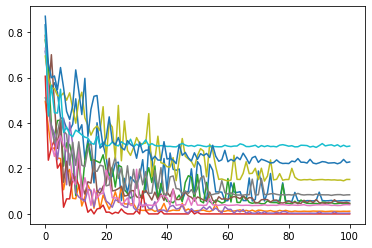

In [20]:
xs = np.arange(res+1)

for topic in sub_topics:
    ys = []
    for noise, topic_scores in means:
        for topic_score in topic_scores:
            if topic_score[0] == topic:
                score = topic_scores[topic-1][1]
                ys.append(score)
    plt.plot(xs, ys, label=topic)

#plt.rc('font', size=13)
#plt.ylabel('$P(\\mathcal{Q})$')
#plt.xlabel('$m$')
#plt.xlim(-1, 15)
#plt.legend()
plt.savefig("noise.png", dpi=300)